#Downloads and imports

In [49]:
!pip install seqeval==1.2.2

!pip install matplotlib==3.4
from seqeval.metrics import accuracy_score, f1_score


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import pandas as pd
import numpy as np

from typing import Tuple, List, Dict, Optional
from collections import Counter, defaultdict

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop
import torch.nn.functional as F
# import torch.optim as optim

torch.manual_seed(42)

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import csv

import sklearn.metrics
import seaborn as sns

import os
import string
import re


In [2]:
import matplotlib
print(matplotlib.__version__)

3.4.0


In [4]:
!git clone https://github.com/botastark/nlp2022-hw1.git

#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#tried with 100d, 200d, 300d, finally 50d are chosen
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt
# !rm glove.6B.300d.txt
!rm glove.6B.zip

Cloning into 'nlp2022-hw1'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 86 (delta 39), reused 26 (delta 4), pack-reused 0
Unpacking objects: 100% (86/86), done.
--2022-07-29 09:29:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-07-29 09:29:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-07-29 09:29:27--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.ed

#Dataset: reading, preprocessing

In [5]:
#datasets
train_path = 'nlp2022-hw1/data/train.tsv'
dev_path = 'nlp2022-hw1/data/dev.tsv'

In [6]:

def read_dataset(path: str) -> Tuple[List[List[str]], List[List[str]]]:
    tokens_s = []
    labels_s = []

    tokens = []
    labels = []
    total_tokens = 0
    with open(path) as f:
        for line in f:

            line = line.strip()

            if line.startswith("#\t"):
                tokens = []
                labels = []
            elif line == "":
                tokens_s.append(tokens)
                labels_s.append(labels)
                total_tokens += len(tokens)
            else:
                token, label = line.split("\t")
                tokens.append(token)
                labels.append(label)

    assert len(tokens_s) == len(labels_s)
    # print( total_tokens )


    return tokens_s, labels_s

In [7]:
#auxiliary function to check labels distribution (does not influence on the solution, just a part of data exploration)
def draw_labels(dataset_path: str, mode: str):

    _, labels = read_dataset(dataset_path)

    counter = Counter(x for xs in labels for x in set(xs))
    fig = plt.figure(figsize=(5, 5))
    classes = list(counter.keys())

    print('{}: '.format(mode), dict(counter))
    sizes = list(counter.values())

    plt.pie(sizes, labels=classes, autopct='%1.1f%%', shadow=True, startangle=90)

    plt.axis('equal')
    fig.savefig('{}.png'.format(mode),  dpi=fig.dpi)

    plt.show()
    

Train:  {'O': 14535, 'B-LOC': 3021, 'B-CW': 3017, 'I-CW': 2345, 'B-PER': 3739, 'I-PER': 3592, 'I-CORP': 1801, 'B-CORP': 2673, 'I-GRP': 2699, 'B-GRP': 2944, 'B-PROD': 2401, 'I-PROD': 1201, 'I-LOC': 1362}


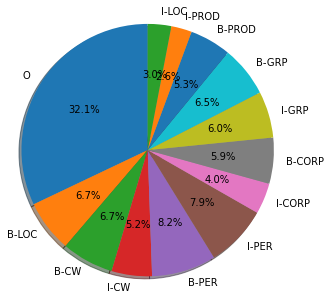

Dev:  {'B-PER': 211, 'O': 765, 'I-PER': 206, 'B-CW': 146, 'I-CW': 109, 'I-GRP': 156, 'B-GRP': 172, 'B-PROD': 124, 'I-PROD': 67, 'B-CORP': 126, 'I-LOC': 85, 'B-LOC': 162, 'I-CORP': 84}


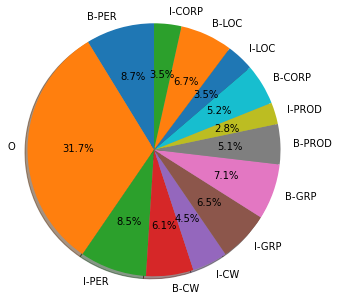

In [8]:
tags = draw_labels(train_path, 'Train')
draw_labels(dev_path, 'Dev')

In [9]:
word_vector = pd.read_csv('glove.6B.300d.txt', sep=" ", header=None,engine='c', quoting=csv.QUOTE_NONE, index_col=0)


glove = {key: val.values for key, val in word_vector.T.items()}

In [10]:
def word2id_builder(word_dataset):
  word2id_dict = {"<UNK>":0, "<PAD>":1}
  id2word_dict = {0: "<UNK>",1: "<PAD>"}
  # for sentence in word_dataset:
  for i, word in enumerate(word_dataset):
    if word not in word2id_dict:
      id = len(word2id_dict)
      word2id_dict[word ] = id
      id2word_dict[id] = word
  return word2id_dict, id2word_dict
words = list(glove.keys())
word2id_dict, id2word_dict = word2id_builder(words)

In [11]:
weight_matrix = np.asarray(list(glove.values()), dtype=np.float32)
vocab_size, emb_dim  = weight_matrix.shape

# for <UNK> take avg of vectors
average_vec = np.mean(weight_matrix, axis=0)
weight_matrix = np.concatenate((average_vec.reshape(1, emb_dim), weight_matrix), axis = 0)
# for <PAD> instert all zeros
weight_matrix = np.concatenate((np.zeros((1, emb_dim)), weight_matrix), axis = 0)

vocab_size  = weight_matrix.shape
print(vocab_size)
print(emb_dim)
# weight_matrix.insert(0, )
weights_matrix_torch = torch.tensor(weight_matrix, dtype=torch.float)

(400000, 300)
300


In [12]:
tags = ["<PAD>","B-PER", "B-LOC", "B-GRP", "B-CORP", "B-PROD", "B-CW", "I-PER", "I-LOC", "I-GRP", "I-CORP", "I-PROD", "I-CW", "O"]
tag2id_dict = {key: value for value, key in enumerate(tags)}
id2tag_dict = {value: key for value, key in enumerate(tags)}
def tags2ids(labels: List[List]) -> List[List]:
  return [[tag2id_dict[label] for label in label_sent] for label_sent in labels]
def ids2tags(label_ids: List[List]) -> List[List]:
  return [[id2tag_dict[id] for id in ids] for ids in label_ids]

In [20]:
def unk_checker(tokens, tags):
    unk_tokens = []
    unk_token_tags = []
    
    for (sent_w, sent_t) in zip(tokens, tags) :
      for (w , t) in zip(sent_w, sent_t):
        # print(w)
        if not w in word2id_dict:
          # sentence_word_vector.append(word2id_dict["<UNK>"])
          unk_tokens.append(w)
          unk_token_tags.append(t)
    return unk_tokens, unk_token_tags

In [22]:
def merger_tags(counter):
  counter_merged = {}
  counter_merged['LOC'] = counter['I-LOC']+counter['B-LOC']
  counter_merged['PER'] = counter['I-PER']+counter['B-PER']
  counter_merged['PROD'] = counter['I-PROD']+counter['B-PROD']
  counter_merged['CORP'] = counter['I-CORP']+counter['B-CORP']
  counter_merged['GRP'] = counter['I-GRP'] +counter['B-GRP']
  counter_merged['CW'] = counter['I-CW'] +counter['B-CW']
  counter_merged['O'] = counter['O']
  counter_merged = dict(sorted(counter_merged.items(), key=lambda item: item[1]))
  return counter_merged

In [31]:
def plot_unk_distr(data):
  tokens, labels = data
  unk_tokens, unk_token_tags = unk_checker(tokens, labels )
  counter_all = Counter(x for xs in labels for x in set(xs))
  counter = Counter(x for x in (unk_token_tags))

  counter_merged = merger_tags(counter)
  counter_merged_all = merger_tags(counter_all)


  sizes = list(counter_merged.values())
  classes = list(counter_merged.keys())
  sizes_all = []
  for c in classes:
    sizes_all.append(counter_merged_all[c])

  fig = plt.figure(figsize=(5, 5))
  fig, ax = plt.subplots()
  width = 1  # the width of the bars

  bars = ax.barh(classes, sizes, width, color =sns.color_palette("husl", 8)) #the green bar has the smallest width as it is contained within the other two
  bars_all = ax.barh(classes, sizes_all,width, edgecolor =sns.color_palette("husl", 8), fill=False) #the blue bar has a greater width than the green bar

  ax.set_ylabel('tags')
  ax.set_title('unknown tokens by tags')
  ax.bar_label(bars, padding=3)

  fig.tight_layout()
  plt.show()


<Figure size 360x360 with 0 Axes>

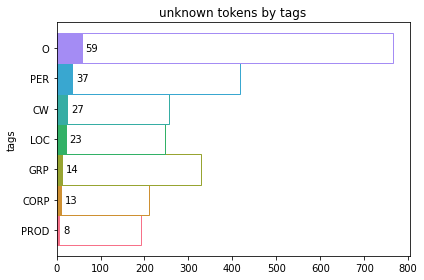

In [32]:

# train_path
plot_unk_distr(read_dataset(dev_path))

In [33]:
#preprocessong function
def sentence2vector(sentenceList: List) -> List:    
    sentence_word_vector = [word2id_dict[w] if w in word2id_dict else word2id_dict["<UNK>"] for w in sentenceList ]
    return sentence_word_vector


In [34]:
#Dataset class
class NERDataset(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str):
        self.sentences = []
        self.labels = []
        self.build(dataset_path)

    def build(self, dataset_path: str) -> None:

        tokens, labels = read_dataset(dataset_path)
        self.sentences = [sentence2vector(sentence) for sentence in tokens]

        self.labels = tags2ids(labels)

    def batch_gen(self, batch_size, shuffle=False, dropout=True):
      n_samples = len(self.sentences)
      if shuffle:
          order = np.random.permutation(n_samples)
      else:
          order = np.arange(n_samples)

      n_batches = n_samples // batch_size
      lengths = []
      for n in range(n_batches):
        max_len_token = 0
        for sent in self.labels[n*batch_size: (n+1)*batch_size]:
          max_len_token = max(max_len_token, len(sent))

        token_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        tag_batch = np.zeros((batch_size, max_len_token), dtype=np.int32)
        lengths.append(max_len_token)
        for i in order[n*batch_size: (n+1)*batch_size]:
          to_fill = max_len_token - len(self.sentences[i])

          token_batch[i-n*batch_size] = np.pad(self.sentences[i], (0, to_fill), 'constant', constant_values=(word2id_dict['<PAD>']))
          tag_batch[i-n*batch_size] =np.pad(self.labels[i], (0, to_fill), 'constant', constant_values=(tag2id_dict["<PAD>"]))
        yield lengths, token_batch, tag_batch, 

#Model

In [35]:
class NER(nn.Module):
    def __init__(self, weight_matrix: torch.Tensor, hparams, device):
        super(NER, self).__init__()
        self.device = device

        self.embedding = nn.Embedding.from_pretrained(weight_matrix)
        self.embedding.requires_grad = False
        self.stacked = hparams.stacked

        _, embedding_dim = weight_matrix.shape

        num_dirs = 1
        if hparams.bi_dir:
          num_dirs = 2
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hparams.hidden_size,
            num_layers=hparams.num_layers,
            batch_first=True,
            bidirectional = hparams.bi_dir
        )

        if hparams.stacked:
          self.lstm2 = nn.LSTM(
              input_size=hparams.hidden_size*num_dirs,
              hidden_size=hparams.hidden_size,
              num_layers=hparams.num_layers,
              batch_first=True,
              bidirectional = hparams.bi_dir
          )

        self.dropout = nn.Dropout(hparams.dropout)
        self.hidden_to_tag = nn.Linear(hparams.hidden_size*num_dirs , 14)
    def init_hidden(self, size):
        # the weights's shape (nb_layers, batch_size, nb_lstm_units)
        num_dirs = 1
        if hparams.bi_dir:
          num_dirs = 2
        hidden_a = Variable(torch.randn(hparams.num_layers*num_dirs, size, hparams.hidden_size))
        hidden_b = Variable(torch.randn(hparams.num_layers*num_dirs, size, hparams.hidden_size))

        return (hidden_a, hidden_b)

    def forward(self, X: torch.Tensor, X_lengths: torch.Tensor):
        batch_size, seq_len = X.shape
        #init weights
        (h_0, c_0) = self.init_hidden(X.shape[0])
        (h_2, c_2) = self.init_hidden(X.shape[0])
  
        # shape(batch_size, seq_len, embedding_dim)
        embedded = self.embedding(X)
        # shape (batch_size, seq_len, numb_lstm_units)
        X_lengths = torch.ones(batch_size, dtype=torch.int32)*X_lengths
        # packing
        packed_embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, X_lengths, batch_first=True)
        #LSTM
        packed_out, (h_n, c_n)  = self.lstm(packed_embedded,  (h_0, c_0))
        #if 2 LSTMs stacked
        if self.stacked:
          packed_out, (h_n, c_n)  = self.lstm2(packed_out,  (h_2, c_2))

        # unpacking
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)

        # shape change for FC layer (batch_size * seq_len, numb_lstm_units) 
        X = X.contiguous()
        X = X.view(-1, X.shape[2])
        # dropout
        X = self.dropout(X)
        # FC
        X = self.hidden_to_tag(X)

        # shape (batch_size, seq_len, 14)
        X = F.log_softmax(X, dim=1)

        X = X.view(batch_size, seq_len, 14)
        Y_hat = X

        return Y_hat

    def neglogloss(self, Y_hat, Y):
        loss_f = torch.nn.NLLLoss()
        # flattening shapes 
        Y_hat = Y_hat.view(-1, Y_hat.shape[2])
        Y = Y.view(-1)
        loss = loss_f(Y_hat, Y)
        # removing PAD tokens (tag2id('<PAD>') = 0)
        mask = (Y > 0).float()
        loss = loss * mask
        return torch.sum(loss) / torch.sum(mask)
        

#Training

In [45]:
def train(device, model: nn.Module, n_epochs: int, optimizer: torch.optim.Optimizer):
    epoch_loss = list()
    val_epoch_loss = list()
    f1_epoch = []
    project_folder = '/content/nlp2022-hw1'
    state_dict_path = os.path.join( project_folder, 'model' )
    early_stopping = True
    early_stopping_mode = 'loss'
    early_stopping_patience = 2
    patience_counter = 0
    
    for epoch in range(n_epochs):
        print('Epoch {}'.format(epoch))
        training_generator = train_dataset.batch_gen(batch_size )
        validation_generator = val_dataset.batch_gen(batch_size )

        losses = list()
        val_losses = []

        model.train()
        for length, x_sample, y_real in training_generator:
            x_sample = torch.tensor(x_sample)
            y_real = torch.LongTensor(y_real)
         
            x_sample = x_sample.to(device)
            y_real = y_real.to(device)

                  #compute loss and make an optimization step
            optimizer.zero_grad()
            Y_hat = model.forward(x_sample, length[-1])
            loss = model.neglogloss(Y_hat, y_real)
            losses.append(loss)
            loss.backward() #calculates the loss of the loss function
            optimizer.step()
        epoch_loss.append(torch.mean(torch.tensor(losses)))
        print('loss {:.3f} \n'.format( epoch_loss[-1]))

        #Validation 
        model.eval()
        f1_batch = []
        for length, x_val, y_real_val in validation_generator: 
            x_val = torch.tensor(x_val)
            y_real_val = torch.LongTensor(y_real_val)
            x_val = x_val.to(device)
            y_real_val = y_real_val.to(device)
            y_hat_val = model.forward(x_val, length[-1])
            val_loss = model.neglogloss(y_hat_val, y_real_val)
            val_losses.append(val_loss.item())
            # f1_batch.append(eval_accuracy(vector2ids(y_hat_val), y_real_val.tolist()))
        # f1_epoch.append(f1_batch)
        val_epoch_loss.append(torch.mean(torch.tensor(val_losses)))
        print('val loss {:.3f} \n'.format( val_epoch_loss[-1]))

        
        # to stop training before overfitting
        if early_stopping:
            # choose metric to monitor
            stop = early_stopping_mode == 'loss' and epoch > 0 and val_epoch_loss[-1] > val_epoch_loss[-2]
            # set patience
            if stop:
                if patience_counter >= early_stopping_patience:
                    # print('Early stop.')
                    break
                else:
                    patience_counter += 1
                    print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')

        torch.save(model.state_dict(), os.path.join(state_dict_path, 'state_{}.pt'.format(epoch)))
    return epoch_loss, val_epoch_loss


#Predict and evaluate

In [37]:
def vector2ids(out):
  tags_per_batch = [[torch.argmax(tag_dist).item() for tag_dist in sentence ] for sentence in out]
  return ids2tags(tags_per_batch) #store all tags per each sentences

In [38]:
def predict(tokens): 
    predictions = []
    tokens_vectors = [sentence2vector(sentence) for sentence in tokens ]
    #convert all sentences into vectors

    with torch.no_grad():
        for j, sentence in enumerate(tokens_vectors): #for each sentence
            
            d_tensor = torch.unsqueeze(torch.as_tensor(sentence), 0)
            out = trial_model(d_tensor, d_tensor.shape[1]).squeeze()
            tags_per_sent = [ torch.argmax(tag_dist).item() for tag_dist in out ]

            predictions.append(tags_per_sent) #store all tags per each sentences

    return ids2tags(predictions)

def eval_accuracy(predictions_s, labels_s, verbose= False):
    labels_s_id = ids2tags(labels_s)


    acc = accuracy_score(flatten(labels_s_id), flatten(predictions_s))
    f = f1_score(labels_s_id, predictions_s, average="macro")
    if verbose:
      print(f"# accuracy: {acc:.4f}")
      print(f"# f1: {f:.4f}")
    return f

In [39]:
# confusion matrix with heat map
def flatten(xss):
    return [x for xs in xss for x in xs]
def plots(Y_true, Y_pred):
  cm = sklearn.metrics.confusion_matrix(flatten(Y_true), flatten(Y_pred))
  # class_names = list(tag2id_dict.keys())[1:]
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=tags, yticklabels=tags)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

#Experiments


In [40]:
tokens, labels = read_dataset(train_path)

tokens, labels = read_dataset(dev_path)


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = NERDataset(train_path)
val_dataset = NERDataset(dev_path)

In [42]:

class HParams():
  bi_dir = True
  stacked = True
  dropout = 0.4 
  hidden_size = 512
  num_layers = 1 
  
hparams = HParams()
batch_size = 32 

patience = 3
epochs = 50 

learning_rate = 1e-3
weight_decay = 1e-6


In [43]:
trial_model = NER(weights_matrix_torch, hparams, device)
optimizer = torch.optim.Adam(trial_model.parameters(), lr=learning_rate)#, weight_decay = weight_decay)

In [46]:
epoch_loss, val_epoch_loss = train(device, trial_model, n_epochs = epochs, optimizer = optimizer)

Epoch 0
loss 0.133 

val loss 0.133 

Epoch 1
loss 0.097 

val loss 0.123 

Epoch 2
loss 0.071 

val loss 0.128 

-- Patience 1 out of 2.

Epoch 3
loss 0.048 

val loss 0.136 

-- Patience 2 out of 2.

Epoch 4
loss 0.034 

val loss 0.144 



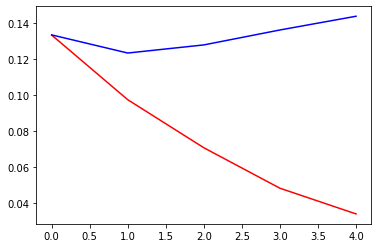

In [47]:
plt.plot(np.array(epoch_loss), 'r', np.array(val_epoch_loss), 'b')

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <PAD> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


# accuracy: 0.9326
# f1: 0.5551


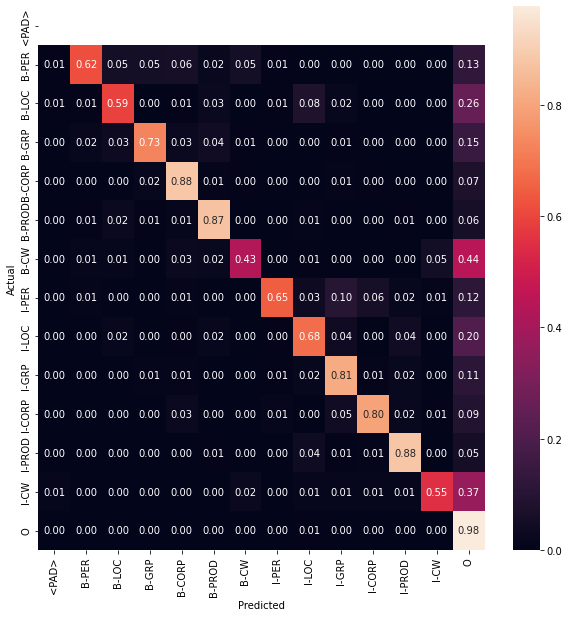

In [51]:
# val_dataset
out = predict(tokens)
eval_accuracy(out, val_dataset.labels, verbose =True)
plots(labels, out)